In [2]:
%matplotlib nbagg
%load_ext autoreload

In [3]:
import concurrent.futures
import functools

In [31]:
import time
import logging

import numpy as np
import ipywidgets
from empyre.vis.colors import ColormapCubehelix
import matplotlib.pyplot as plt
import scipy.ndimage

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
from libertem.corrections.coordinates import flip_y, rotate_deg, identity
from libertem.analysis import com as com_analysis
from libertem.udf.masks import ApplyMasksUDF
from libertem.udf.raw import PickUDF
from libertem.common.container import MaskContainer
from libertem.viz.bqp import BQLive2DPlot

In [7]:
from libertem.api import Context
from libertem.executor.inline import InlineJobExecutor

In [8]:
from ptychography40.reconstruction.ssb import SSB_UDF, generate_masks
from ptychography40.reconstruction.common import (
    wavelength, get_shifted, diffraction_to_detector, image_transformation_matrix, apply_matrix
)

In [9]:
ctx = Context(executor=InlineJobExecutor())

In [10]:
ds = ctx.load('auto', '/Users/weber/LargeData/ER-C-1/groups/data_science/data/reference/MIB/20200518 165148/default.hdr')

### SSB setup

See also https://ptychography-4-0.github.io/ptychography/algorithms/ssb.html for a more complete example!

In [11]:
# Acceleration voltage in keV
U = 300
rec_params = {
    "dtype": np.float32,
    "lamb": wavelength(U),
    "dpix": 12.7e-12,
    "semiconv": 22.1346e-3,  # 2020-05-18
    "semiconv_pix": 31,  # 2020-05-18
    # applied right to left
    "transformation": rotate_deg(88) @ flip_y(),
    "cx": 123,
    "cy": 126,
    "cutoff": 16,  # number of pixels: trotters smaller than this will be removed
}
cutoff_freq = np.float32('inf')

mask_params = {
    # Shape of the reconstructed area
    'reconstruct_shape': tuple(ds.shape.nav),
    # Shape of a detector frame
    'mask_shape': tuple(ds.shape.sig),
    # Use the faster shifting method to generate trotters
    'method': 'shift',
}

In [12]:
%%time
trotters = generate_masks(**rec_params, **mask_params)

KeyboardInterrupt: 

CPU times: user 7.33 s, sys: 78 ms, total: 7.41 s
Wall time: 7.41 s


In [11]:
mask_container = MaskContainer(
    mask_factories=lambda: trotters, dtype=trotters.dtype, count=trotters.shape[0]
)

In [12]:
ssb_udf = SSB_UDF(**rec_params, mask_container=mask_container)

In [13]:
# Create the plots for the SSB result
p0 = BQLive2DPlot(ds, ssb_udf, channel="phase")
p1 = BQLive2DPlot(ds, ssb_udf, channel="amplitude")

### COM setup

This example uses [advanced live plotting features of LiberTEM](https://libertem.github.io/LiberTEM/udf/basic.html#live-plotting) to create a live plot of the data analysis that the [COM Analysis](https://libertem.github.io/LiberTEM/reference/api.html#libertem.api.Context.create_com_analysis) performs.

In [14]:
# Masks are sum, y gradient, x gradient
masks = com_analysis.com_masks_factory(
    detector_y=ds.shape.sig[0],
    detector_x=ds.shape.sig[1],
    cx=rec_params["cx"],
    cy=rec_params["cy"],
    r=rec_params["semiconv_pix"] + 30,
)

com_udf = ApplyMasksUDF(masks)    

def center_shifts(udf_result):
    '''
    Derive center of mass results from the UDF results
    and apply coordinate correction.
    '''
    y_centers_raw, x_centers_raw = com_analysis.center_shifts(
        img_sum=udf_result['intensity'].data[..., 0],
        img_y=udf_result['intensity'].data[..., 1],
        img_x=udf_result['intensity'].data[..., 2],
        ref_y=rec_params["cy"],
        ref_x=rec_params["cx"],
    )
    shape = y_centers_raw.shape
    y_centers, x_centers = rec_params['transformation'] @ (y_centers_raw.reshape(-1), x_centers_raw.reshape(-1))

    y_centers = y_centers.reshape(shape)
    x_centers = x_centers.reshape(shape)
    return (y_centers, x_centers)
    

def field(udf_result, damage):
    ch = ColormapCubehelix(start=1, rot=1, minLight=0.5, maxLight=0.5, sat=2)
    shifts = center_shifts(udf_result)
    # damage = True because of https://github.com/LiberTEM/LiberTEM/issues/1052
    return (ch.rgb_from_vector((shifts[0], shifts[1], 0)), True)

def magnitude(udf_result, damage):
    return (com_analysis.magnitude(*center_shifts(udf_result)), damage)

def divergence(udf_result, damage):
    return (com_analysis.divergence(*center_shifts(udf_result)), damage)

def curl(udf_result, damage):
    return (com_analysis.curl_2d(*center_shifts(udf_result)), damage)

def y(udf_result, damage):
    return (center_shifts(udf_result)[0], damage)

def x(udf_result, damage):
    return (center_shifts(udf_result)[1], damage)

com_plots = []

for f in field, magnitude, divergence, curl, y, x:
    p = BQLive2DPlot(
        dataset=ds,
        udf=com_udf,
        channel=f,
    )
    com_plots.append(p)

### Plot setup for gridded display

In [15]:
plots = [p0, p1] + com_plots

In [16]:
# NBVAL_IGNORE_OUTPUT
# (output is ignored in nbval run because it somehow doesn't play nice with bqplot)

outputs = []

for p in plots:
    # Capture the plots to display them in a grid later
    output = ipywidgets.Output()
    with output:
        p.display()
        # Some plot-specific tweaks for grid display
        if isinstance(p, BQLive2DPlot):
            p.figure.fig_margin={'top': 50, 'bottom': 0, 'left': 25, 'right': 25}
            p.figure.layout.width = '400px'
            p.figure.layout.height = '400px'
        elif isinstance(p, MPLLive2DPlot):
            p.fig.tight_layout()
            p.fig.set_size_inches((3, 3))
            p.fig.canvas.toolbar_position = 'bottom'
    outputs.append(output)

In [17]:
ipywidgets.VBox([
    ipywidgets.HBox(outputs[0:2]),
    ipywidgets.HBox(outputs[2:4]),
    ipywidgets.HBox(outputs[4:6]),
    ipywidgets.HBox(outputs[6:8]),
])

### Run SSB and centre of mass on live data

This updates the plots above.

In [43]:
res = ctx.run_udf(dataset=ds, udf=[ssb_udf, com_udf], plots=plots)

In [13]:
probe_angular = tuple(ds.shape.nav)

In [14]:
pixel_size_diffracted = 1/rec_params['dpix']/probe_angular[0]*rec_params['lamb']

In [15]:
pixel_size_diffracted

0.001211090613118159

In [16]:
y, x = np.ogrid[:probe_angular[0], :probe_angular[1]]

In [17]:
y_real = (y - probe_angular[0]/2) * pixel_size_diffracted
x_real = (x - probe_angular[1] / 2) * pixel_size_diffracted

In [18]:
probe = np.sqrt(y_real**2 + x_real**2) <= rec_params['semiconv']
fourier_probe = np.fft.fftshift(np.fft.fft2(probe))

In [104]:
exit_wave = fourier_probe * res[0]['complex'].data

In [110]:
projected = np.fft.fft2(exit_wave)

<IPython.core.display.Javascript object>


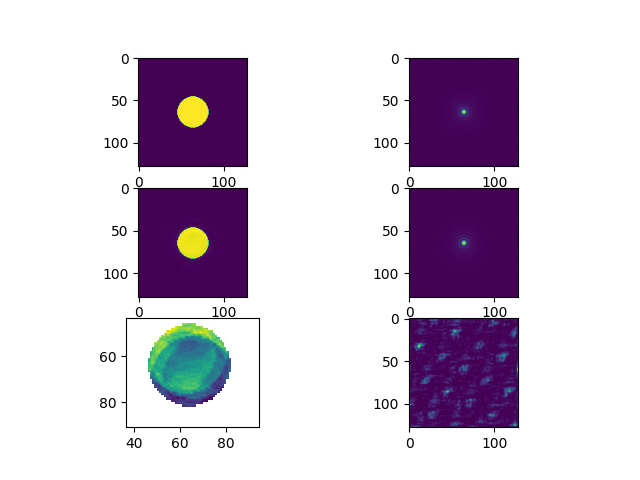

/Users/weber/.conda/envs/ptycho37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [111]:
fig, axes = plt.subplots(3, 2)
axes[0, 0].imshow(probe)
axes[0, 1].imshow(np.abs(fourier_probe))
axes[1, 1].imshow(np.abs(exit_wave))
axes[1, 0].imshow(np.abs(projected))
axes[2, 1].imshow(np.abs(res[0]['complex'].data))
axes[2, 0].imshow(np.abs(projected)**2 / np.abs(probe)**2)

In [67]:
roi = np.zeros(ds.shape.nav, dtype=bool)
roi[probe_angular[0]//2, probe_angular[1]//2] = True

In [68]:
picked = ctx.run_udf(dataset=ds, udf=PickUDF(), roi=roi)

INFO:libertem.common.numba.cache:numba cache miss <function make_get_read_ranges.<locals>._get_read_ranges_inner at 0x7f21b6d25c20> <function make_get_read_ranges.<locals>._get_read_ranges_inner at 0x7f21b6d25c20>
INFO:libertem.common.numba.cache:numba cache miss <function _make_mmap_reader_and_decoder.<locals>._mmap_tilereader_w_copy at 0x7f20d805ccb0> <function _make_mmap_reader_and_decoder.<locals>._mmap_tilereader_w_copy at 0x7f20d805ccb0>


In [77]:
target_shape = probe_angular
source_shape = tuple(ds.shape.sig)

In [86]:
f = functools.partial(
    diffraction_to_detector,
    lamb=rec_params['lamb'],
    diffraction_shape=target_shape,
    pixel_size_real=rec_params['dpix'],
    pixel_size_detector=rec_params['semiconv'] / rec_params['semiconv_pix'],
    cy=rec_params['cy'],
    cx=rec_params['cx'],
    flip_y=True,
    scan_rotation=88.
)

In [87]:
%autoreload
mat = image_transformation_matrix(
    source_shape=source_shape,
    target_shape=target_shape,
    affine_transformation=f,
)

In [88]:
%autoreload
extracted = apply_matrix(picked['intensity'].data, mat, target_shape)

<IPython.core.display.Javascript object>


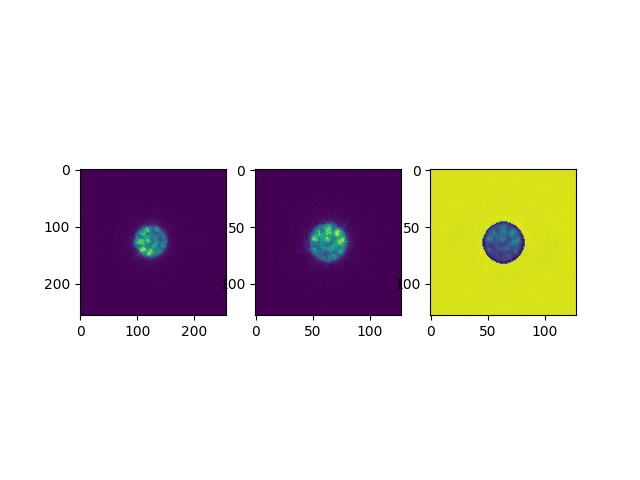

In [94]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(picked['intensity'].data[0])
axes[1].imshow(extracted[0])
axes[2].imshow(extracted[0] - np.abs(projected)*20)

<IPython.core.display.Javascript object>


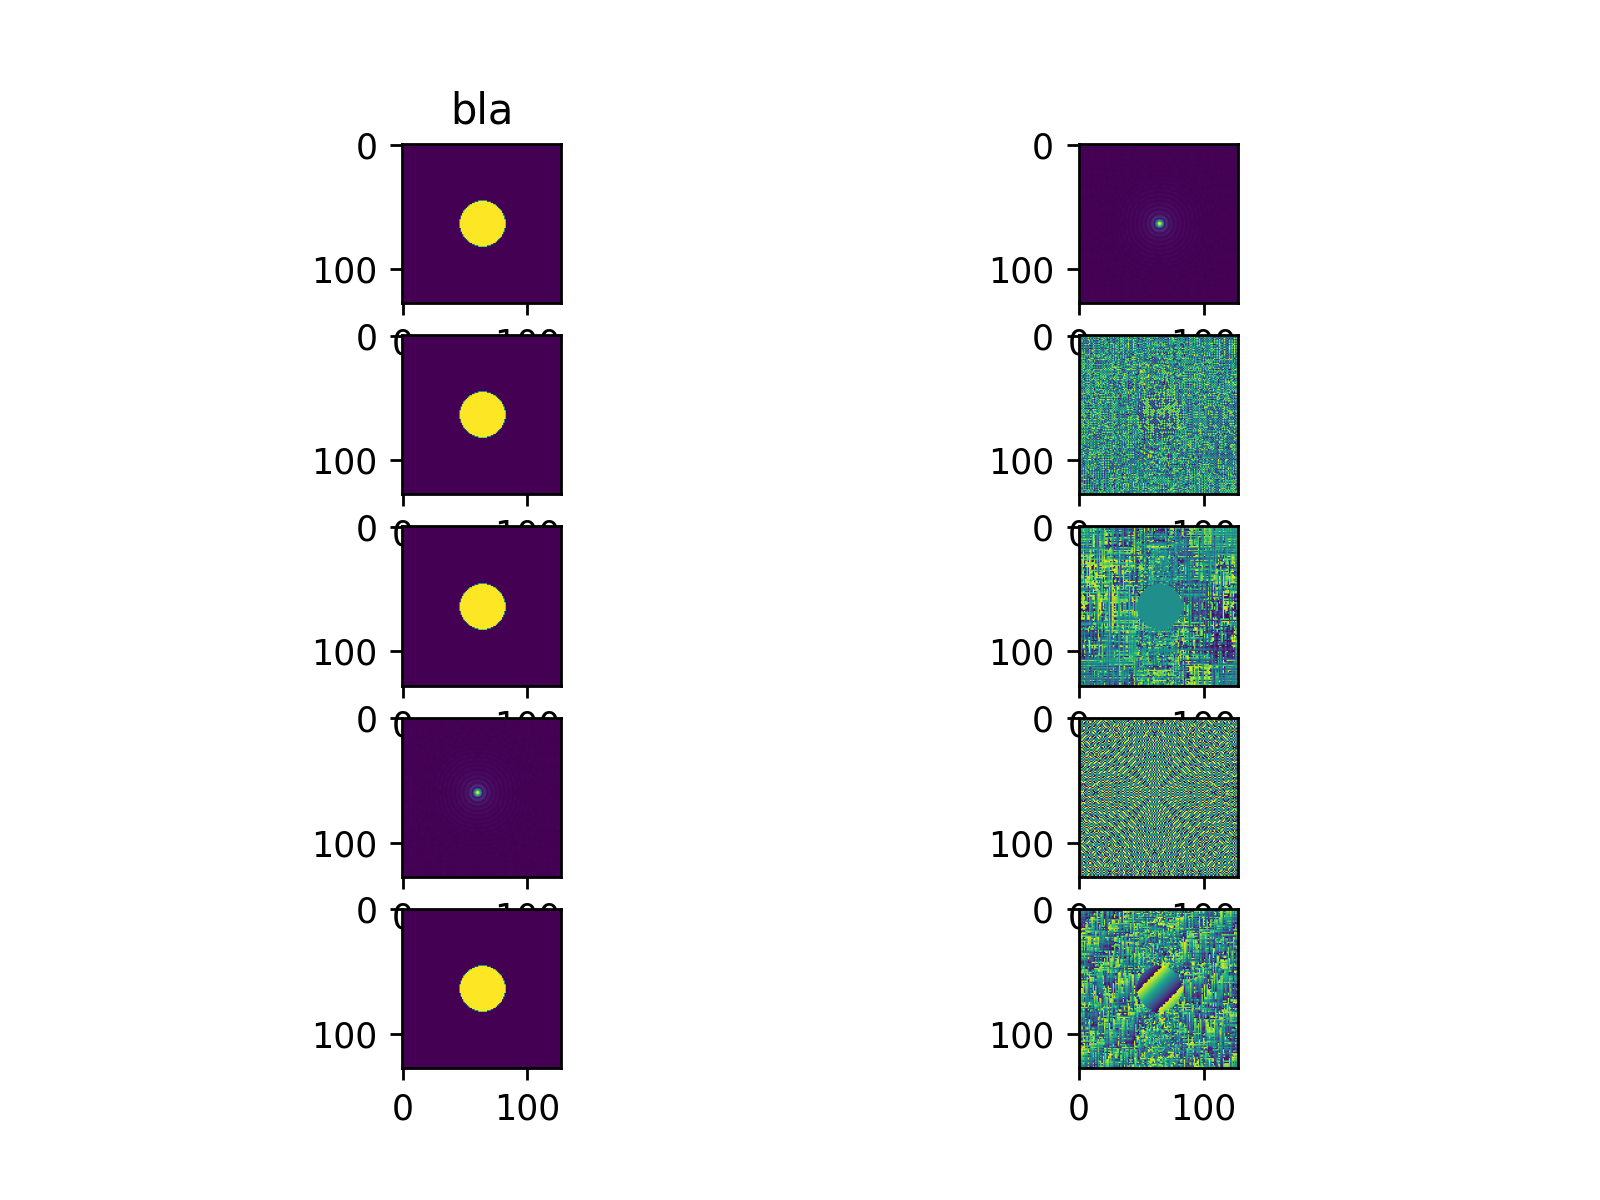

In [47]:
fig, axes = plt.subplots(5, 2)
axes[0, 0].imshow(probe*1)
axes[0, 0].set_title("bla")
axes[0, 1].imshow(np.abs(fourier_probe))
ifft_probe = np.fft.ifft2(fourier_probe)
axes[1, 0].imshow(np.abs(ifft_probe))
axes[1, 1].imshow(np.angle(ifft_probe))
shifted_ifft_probe = np.fft.ifft2(np.fft.ifftshift(fourier_probe))
axes[2, 0].imshow(np.abs(shifted_ifft_probe))
axes[2, 1].imshow(np.angle(shifted_ifft_probe))
rolled_probe = np.roll(fourier_probe, shift=(-4, -4), axis=(0, 1))
axes[3, 0].imshow(np.abs(rolled_probe))
axes[3, 1].imshow(np.angle(rolled_probe))
half_shifted_ifft_probe = np.fft.ifft2(np.fft.ifftshift(rolled_probe))
axes[4, 0].imshow(np.abs(half_shifted_ifft_probe))
axes[4, 1].imshow(np.angle(half_shifted_ifft_probe))

In [43]:
np.allclose(probe, np.fft.ifft2(np.fft.fft2(probe)))

True